In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

In [2]:
from src.PortfolioIndicator import PortfolioIndicator
from src.PortfolioConstructor import PortfolioConstructor

In [3]:
def calculate_ret(x):
    
    x = x.resample("BM").last()
    
    ret = x["a_price"].pct_change().shift(-1)
    
    return ret

### Import dataset

In [73]:
data_directory = "data/"
file = "ab_stock_cross_section.csv"

In [74]:
df = pd.read_csv(data_directory+file)
df = df.iloc[:,1:]
df["date"] = pd.to_datetime(df["date"])

In [75]:
df = df[df["date"]>"2001-03-01"] # filter out data that is after AB merge

In [76]:
a_price_df = pd.pivot_table(df,values="a_price",index="date",columns="unique_id")
b_price_df = pd.pivot_table(df,values="b_price",index="date",columns="unique_id")

### Create Portfolio Indicator

In [77]:
ratio_df = df[["date","unique_id","ratio"]]
ratio_df = ratio_df.set_index("date")

#### Try a monthly indicator rebalance

In [78]:
monthly_ratio_df = ratio_df.groupby("unique_id").resample("BM").last().dropna()

In [79]:
monthly_ratio_df["date"] = monthly_ratio_df.index.to_frame()["date"]
monthly_ratio_df.index = range(0,monthly_ratio_df.shape[0])
monthly_ratio_df.columns = ["ticker","ratio","date"]

#### Create a series of update time

In [80]:
rebalance_date_series = list(set(monthly_ratio_df.date))

In [84]:
monthly_ratio_df["ratio"]

0        2.055854
1        1.878269
2        1.640945
3        1.808442
4        2.248750
           ...   
18575    2.402402
18576    2.135447
18577    2.216718
18578    2.400000
18579    2.134043
Name: ratio, Length: 18580, dtype: float64

#### Create Portfolio Indicator

In [85]:
indicator_constructor = PortfolioIndicator()

initialized.


In [97]:
indicator_df = indicator_constructor.create_indicator(df=monthly_ratio_df,
                                                      var_name="ratio",
                                                      rebalance_date_series=rebalance_date_series,
                                                      number=3,
                                                      top_n=False)

#### Create Monthly Return DataFrame

In [98]:
price_df = df[["date","unique_id","a_price"]]
price_df = price_df.set_index("date")

In [99]:
ret_df = price_df.groupby("unique_id").apply(calculate_ret)

In [100]:
index_ret_df = ret_df.index.to_frame()
index_ret_df["ret"] = ret_df
index_ret_df.index = range(0,index_ret_df.shape[0])
index_ret_df.columns = ["ticker","date","ret"]
index_ret_df = index_ret_df.dropna()

In [102]:
merge_df = index_ret_df.merge(indicator_df,on=["ticker","date"],how="inner")

### Construct Portfolio Based on Indicator

In [104]:
portfolio_constructor = PortfolioConstructor(merge_df)

In [105]:
portfolio_return_df = portfolio_constructor.create_portfolio_series(var_name="ratio_indicator",equal_weight=True)

In [107]:
portfolio_cum_return_df = (portfolio_return_df+1).cumprod()

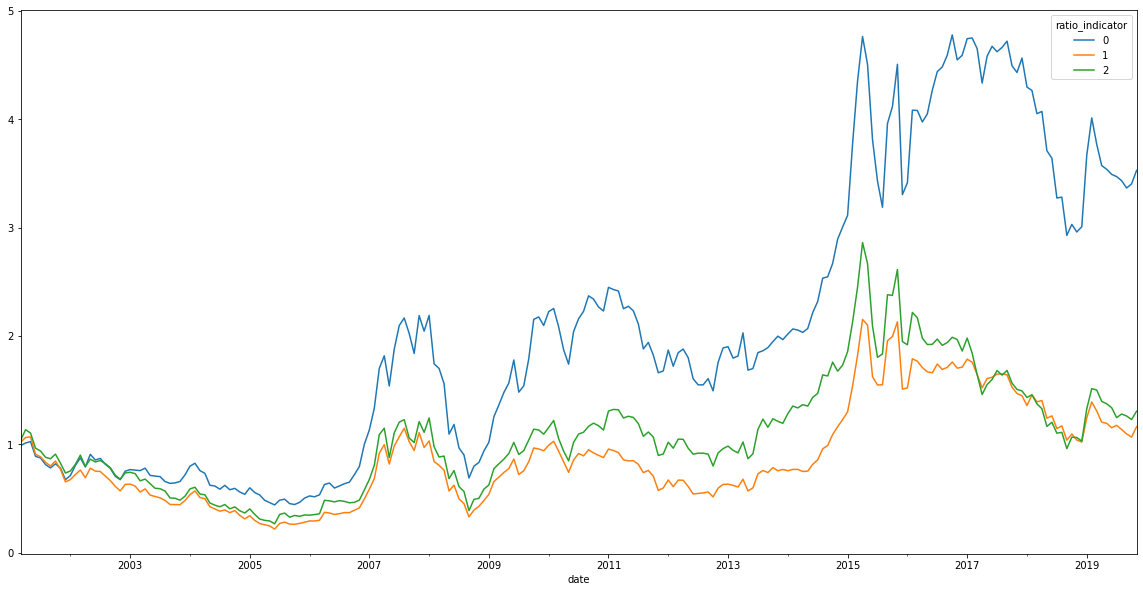

In [108]:
portfolio_cum_return_df.plot(figsize=(20,10))

In [112]:
factor_return = portfolio_return_df.iloc[:,0] - portfolio_return_df.iloc[:,-1]

In [113]:
factor_cum_return = (factor_return+1).cumprod()

### Other Factor Model Explanation

In [176]:
test_asset_return = portfolio_return_df.iloc[:,-1].shift(1)

In [179]:
ff_factor_df = pd.read_excel("data/ff_3_factor_monthly.xls")

In [180]:
ff_factor_df["日期_Date"] = pd.to_datetime(ff_factor_df["日期_Date"])
ff_factor_df = ff_factor_df.set_index("日期_Date")
ff_factor_df = ff_factor_df.resample("M").last()

In [181]:
test_asset_return = test_asset_return.resample("M").last()

In [182]:
merge_factor_return_df = pd.concat([test_asset_return,ff_factor_df],axis=1).dropna()

In [183]:
y_return = merge_factor_return_df.iloc[:,0]
x_factor_df = merge_factor_return_df.iloc[:,1:4]
x_factor_df = sm.add_constant(x_factor_df)

In [185]:
model = sm.OLS(y_return,x_factor_df)
results = model.fit()

In [186]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      2   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     517.2
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           2.47e-99
Time:                        20:14:22   Log-Likelihood:                 423.84
No. Observations:                 224   AIC:                            -839.7
Df Residuals:                     220   BIC:                            -826.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0035      0.002     -1.391      0.166      -0.008       0.001
市场溢酬因子__流通市值加权_Rmrf_tmv     0.9784      0.031     31.187      0.000       0.917       1.040
市值因子__流通市值加权_Smb_tmv        0.9965      0.068     14.741      0.000       0.863       1.130
账面市值比因子__流通市值加权_Hml_tmv     0.1456      0.090      1.610      0.109      -0.033       0.324
==============================================================================
Omnibus:                       33.068   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.352
Skew:                           0.541   Prob(JB):                     6.61e-25
Kurtosis:                       6.280   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""